In [2]:
import sqlalchemy
import pandas as pd
pd.set_option('display.max_rows', None)

url_object = sqlalchemy.engine.URL.create(
    "postgresql+psycopg2",
    username="pguser",
    password="pgpass",
    host="localhost",
    database="finance_dwh",
    port=5431
)

engine = sqlalchemy.create_engine(
    url_object)


query_str = """select description, count(*) cnt
from public.company_facts group by description order by cnt desc limit 100

"""

#pd.read_sql_query(query_str, con=engine)

In [7]:
import numpy as np
from scipy.stats import linregress
from datetime import date

query_str = """select 
 "end", 
  val,
  ticker
from public.company_facts 
where description = 'ProfitLoss' and fy > 2020 and val != 0 and frame is not null and length(frame) != 6
order by ticker, "end" asc limit 50000

"""

df = pd.read_sql_query(query_str, con=engine)
df['rolling_slope'] = (df.groupby('ticker')['val']
   .rolling(window=4) 
   .apply(lambda v: linregress(np.arange(len(v)), v).slope )
   .reset_index(level=0, drop=True)
)
print(df.shape)

(31334, 4)


In [26]:
new_df = df.copy()
print(new_df.loc[new_df['ticker'] == 'XOM'])
new_df = df.sort_values('end', ascending=False).drop_duplicates(["ticker"])


new_df = new_df.sort_values(['rolling_slope'], ascending=[False])
new_df['analysis_rank'] = new_df.reset_index().index + 1

new_df['analysis_percentile_rank'] = (new_df['rolling_slope'].rank(pct=True) * 100).round().fillna(0.0).astype(int)
new_df[:100]

              end          val ticker  rolling_slope
31000  2020-03-31   -770000000    XOM            NaN
31001  2020-06-30  -1169000000    XOM            NaN
31002  2020-09-30   -709000000    XOM            NaN
31003  2021-03-31   2796000000    XOM   1.115800e+09
31004  2021-06-30   4781000000    XOM   2.135500e+09
31005  2021-09-30   6942000000    XOM   2.493800e+09
31006  2022-03-31   5750000000    XOM   1.102300e+09
31007  2022-06-30  18574000000    XOM   4.018700e+09
31008  2022-09-30  20198000000    XOM   5.259200e+09


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

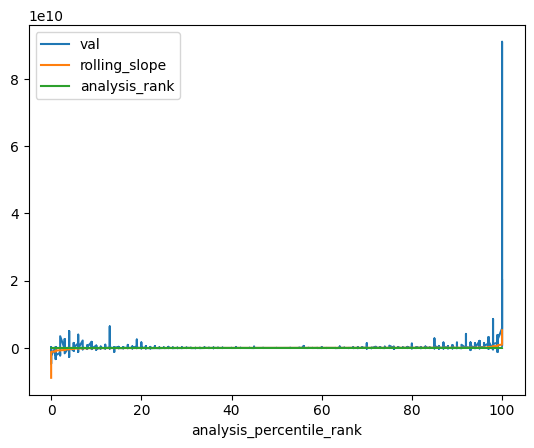

In [ ]:

import matplotlib.pyplot as plt
query_str = """select 
 "end", 
  val,
  ticker,
  description,
  form,
  filed,
  frame
from public.company_facts 
where val != 0 and ticker = 'AMCR' and description = 'ProfitLoss' and frame is not null and length(frame) != 6
order by frame, val desc limit 50000


"""



new_df.plot(x='analysis_percentile_rank',)

plt.show()